In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from classifier.model import DiffCG, MinCutCG, DMoNCG, DeepCG
from classifier.train import training
from classifier.test import test


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

In [2]:
model = DeepCG(training_dataset.num_node_features)

28.06.2022 14:34:15 Creating Training Directory at 2022-06-28_14-34_DeepCG/
28.06.2022 14:34:15 Using CUDNN Benchmark
28.06.2022 14:34:18 Loading Datasets
28.06.2022 14:34:18 Start Training


Epoch 0: Training loss 15.6750; Validation loss 21.2279, MAE: 21.7181; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 5: Training loss 5.9416; Validation loss 14.2381, MAE: 14.7344; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 10: Training loss 5.5020; Validation loss 14.4936, MAE: 14.9867; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 15: Training loss 5.3464; Validation loss 14.9221, MAE: 15.4157; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 20: Training loss 5.3456; Validation loss 15.0290, MAE: 15.5213; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 25: Training loss 5.1799; Validation loss 15.4471, MAE: 15.9416; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 30: Training loss 5.0398; Validation loss 15.1771, MAE: 15.6705; lr: 0.00100
	Add. Loss: Training 0.0000, Validation 0.0000
Epoch 35: Training loss 4.8239; Validation loss 16.4082, MAE: 16.9033; lr: 0.00100
	Add. Lo

28.06.2022 14:46:43 Training took 0.21 hours
28.06.2022 14:46:43 Minimum Training Loss 3.0796 in epoch 388
28.06.2022 14:46:43 Minimum Validation Loss (after 0 epochs) 13.9336 in epoch 297
28.06.2022 14:46:43 Minimum MAE (after 0 epochs) 14.4285 in epoch 297
28.06.2022 14:46:43 Seed used for training was: 15802407325324903030


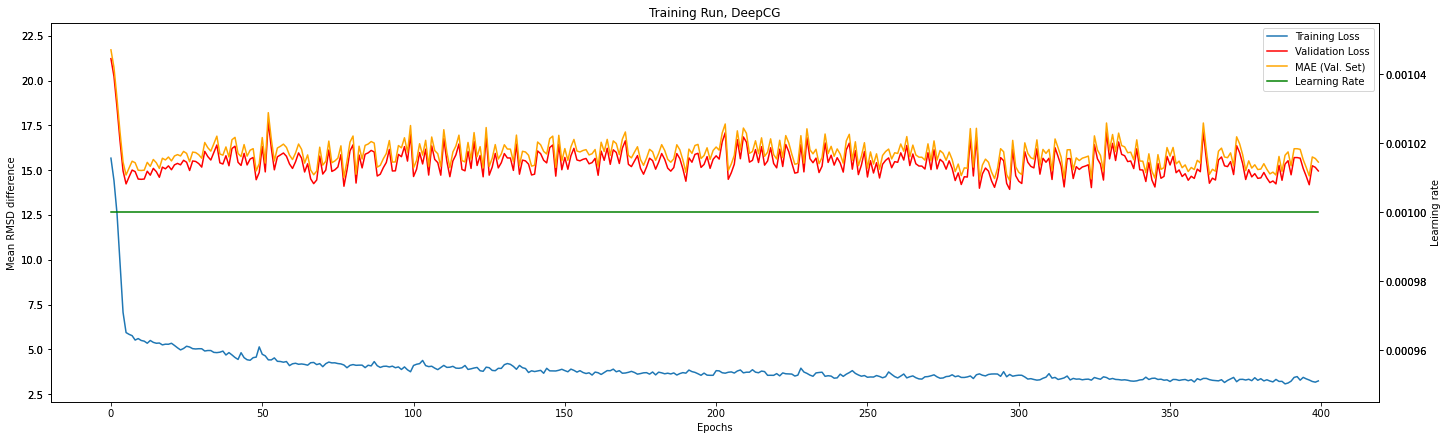

In [3]:
#Training
parent_dir = "run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=400,
    sched_T0=0,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=0)

In [4]:
#get training run data

run_dir = "run_data/2022-06-28_14-34_DeepCG"
burn_in = 30

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 3.0796 in epoch 388
Minimum Validation Loss (after 30 epochs) 13.9336 in epoch 297
Minimum MAE (after 30 epochs) 14.4285 in epoch 297


Validation Loss at 297 is 13.9336
5 before select
14.0472, 14.6223, 15.7076, 15.5369, 14.2667
5 after select
16.1796, 14.6937, 14.3912, 14.2611, 16.0343
MAE at 297 is 14.4285


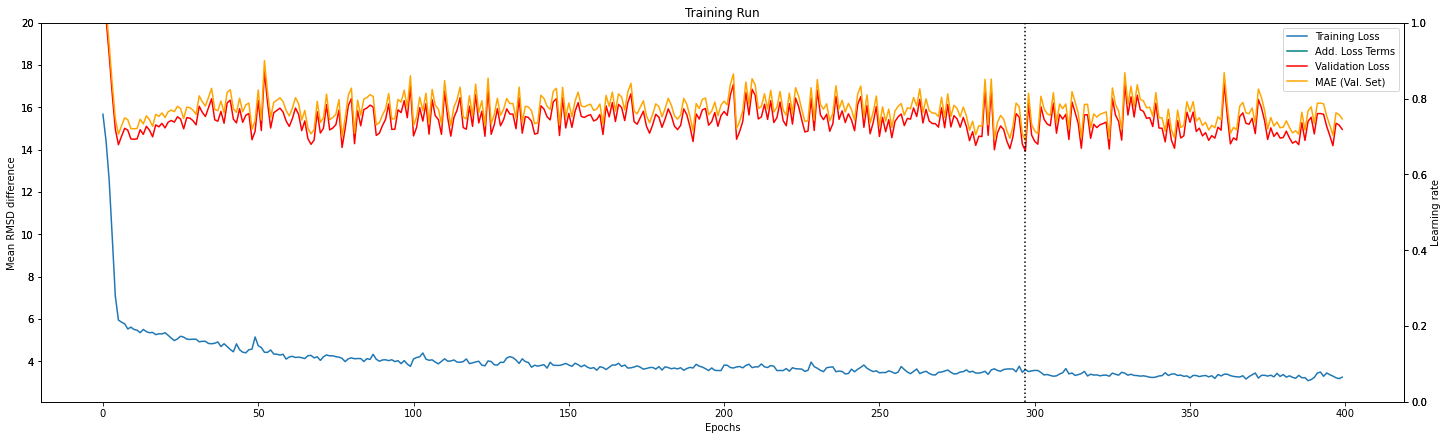

In [5]:
#plot the training run
select = 297

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ylim([(min(epoch_losses)-1), 20]) #max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0, c = "black", ls = "--")

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 297
Test Set
Minimum Loss: Label = 16.8240, Prediction = 16.7658, Loss = 0.0017
Maximum Loss: Label = 41.4410, Prediction = 16.2443, Loss = 24.6967
Mean Test loss: 	 10.7484
Std. Dev. of Test loss:  6.4883
Min loss: 		 0.0017
First Quantile: 	 5.5383
Median: 		 9.4265
Third Quantile: 	 16.4124
Max Loss: 		 24.6967
LinregressResult(slope=0.06803283897582214, intercept=15.519881557733706, rvalue=0.012800549892587677, pvalue=0.832037672188463, stderr=0.3204704847178009, intercept_stderr=6.145161376734036)


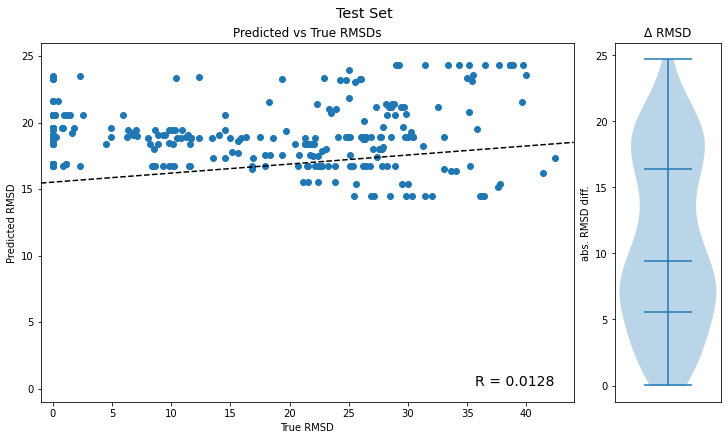

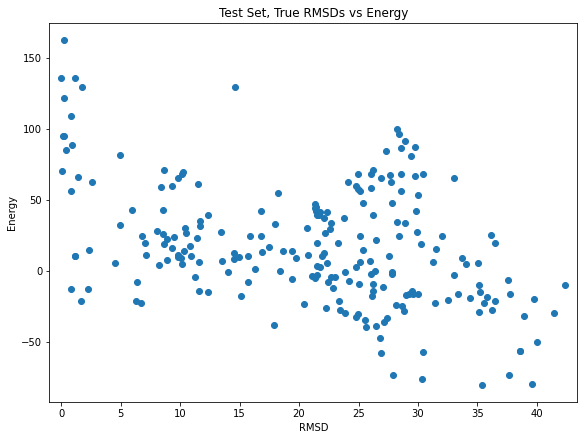

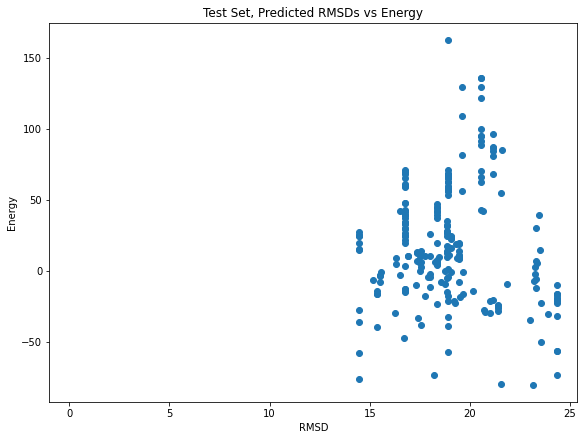

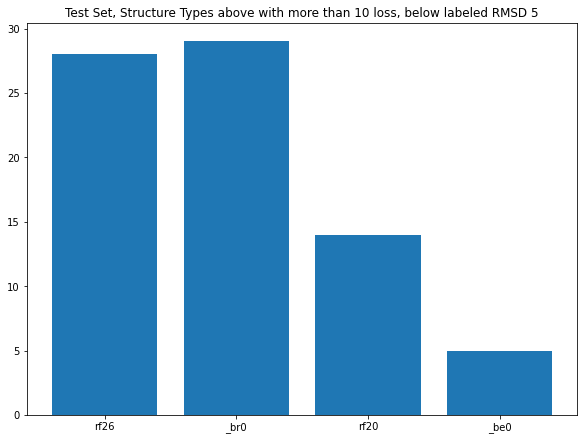

5S and tRNA Test Set
Minimum Loss: Label = 20.1240, Prediction = 20.1069, Loss = 0.0001
Maximum Loss: Label = 0.0000, Prediction = 26.6886, Loss = 26.1886
Mean Test loss: 	 6.6874
Std. Dev. of Test loss:  6.9108
Min loss: 		 0.0001
First Quantile: 	 1.4808
Median: 		 3.9946
Third Quantile: 	 9.3389
Max Loss: 		 26.1886
LinregressResult(slope=0.5538232367659303, intercept=4.5852052561504575, rvalue=0.15868146106975214, pvalue=1.5267419517504132e-07, stderr=0.10480799056077753, intercept_stderr=2.1568837364270976)


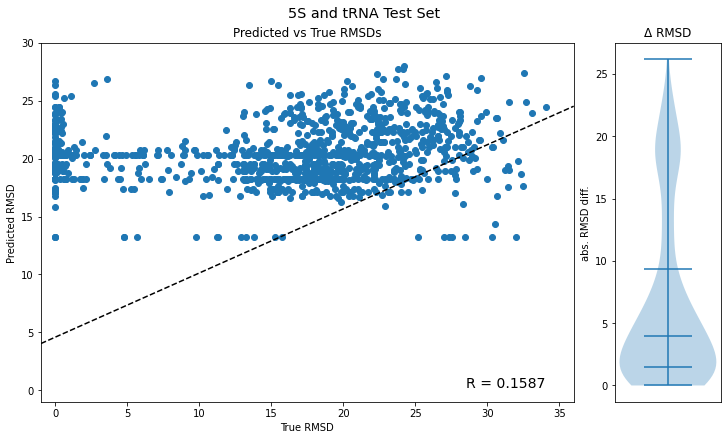

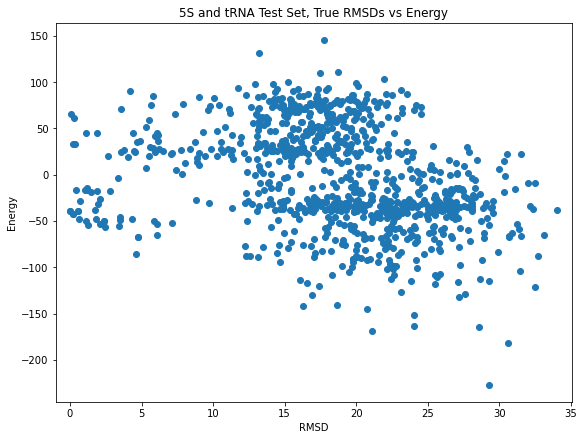

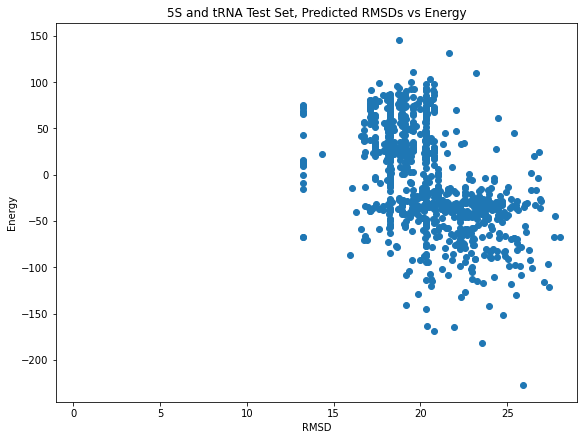

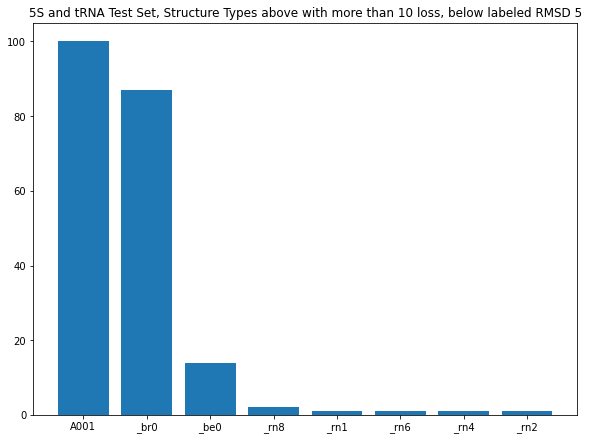

Training Set
Minimum Loss: Label = 26.0750, Prediction = 26.0818, Loss = 0.0000
Maximum Loss: Label = 0.1620, Prediction = 27.9536, Loss = 27.2916
Mean Test loss: 	 6.9133
Std. Dev. of Test loss:  5.8697
Min loss: 		 0.0000
First Quantile: 	 2.2743
Median: 		 5.6474
Third Quantile: 	 9.9261
Max Loss: 		 27.2916
LinregressResult(slope=0.8930280699004675, intercept=-1.0577618727695288, rvalue=0.26836664161151175, pvalue=5.286621196295816e-14, stderr=0.11643167111376576, intercept_stderr=2.492180784589849)


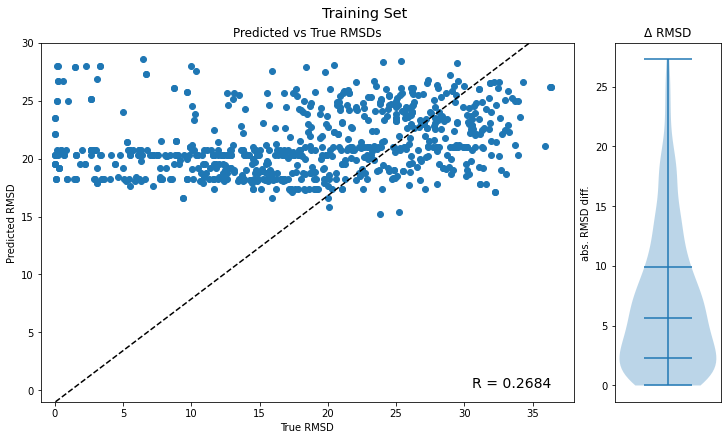

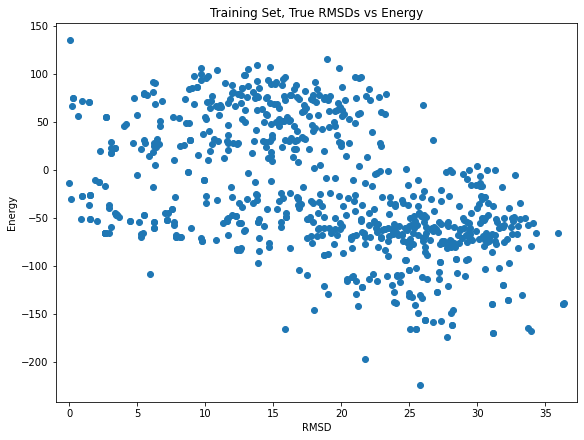

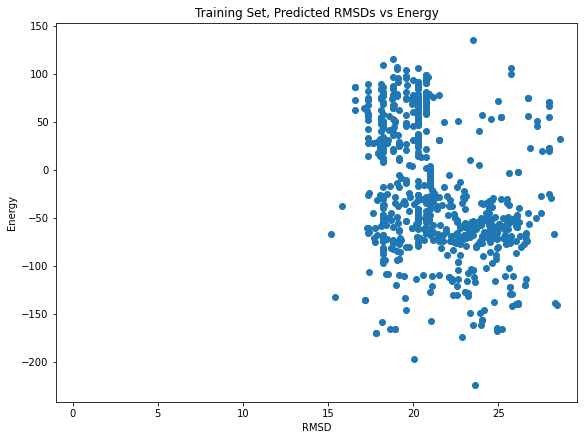

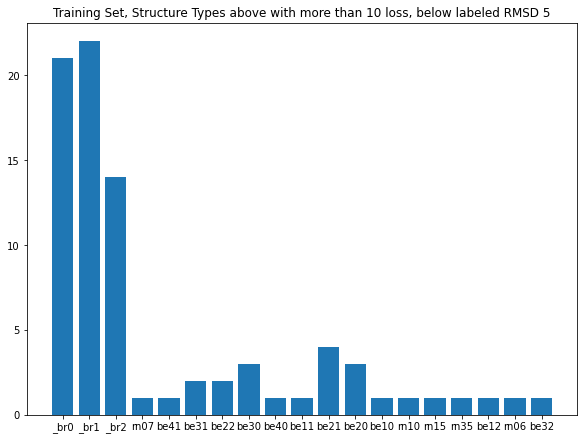

Validation Set
Minimum Loss: Label = 18.8330, Prediction = 18.8488, Loss = 0.0001
Maximum Loss: Label = 61.9850, Prediction = 19.6101, Loss = 41.8749
Mean Test loss: 	 12.9620
Std. Dev. of Test loss:  9.3270
Min loss: 		 0.0001
First Quantile: 	 4.8409
Median: 		 11.9004
Third Quantile: 	 19.4504
Max Loss: 		 41.8749
LinregressResult(slope=0.30894585062768953, intercept=16.849532309968815, rvalue=0.06535659698817183, pvalue=0.19433665567485323, stderr=0.237637676214518, intercept_stderr=4.98517840897551)


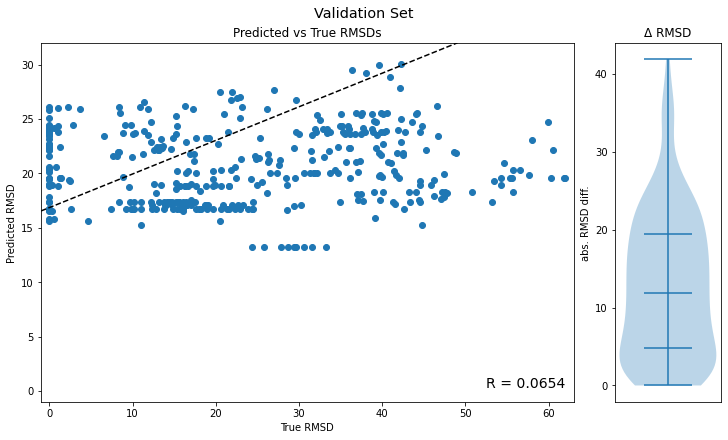

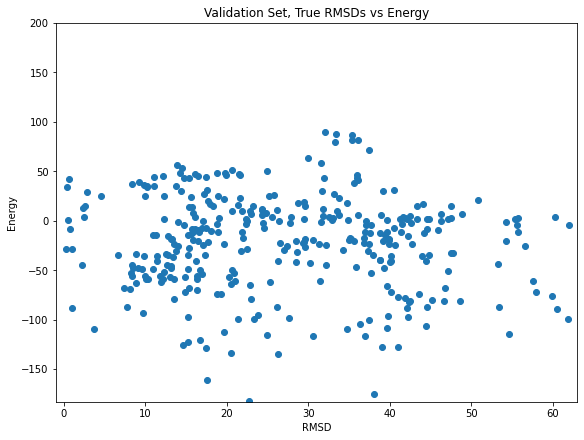

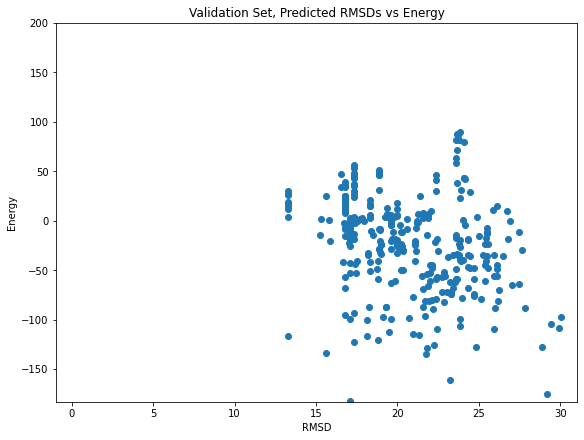

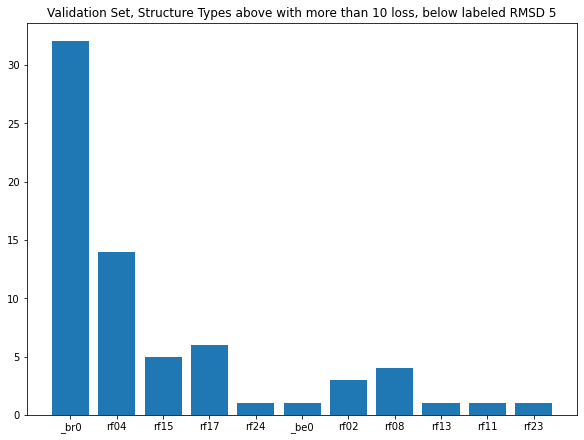

LinregressResult(slope=0.5757569294295898, intercept=9.166732731365785, rvalue=0.1631078226503056, pvalue=2.3680705188667627e-10, stderr=0.09025302705396689, intercept_stderr=1.845177263449273)


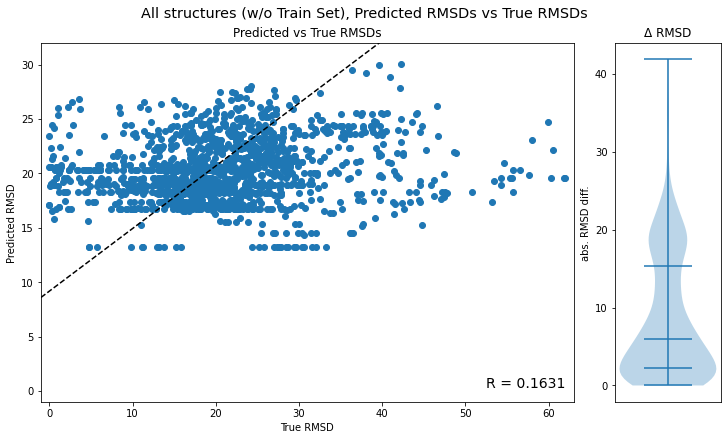

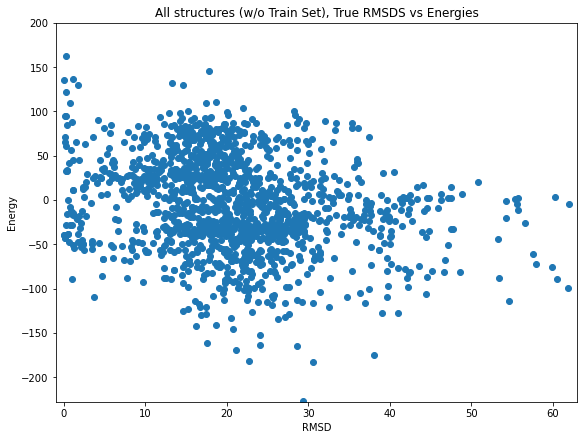

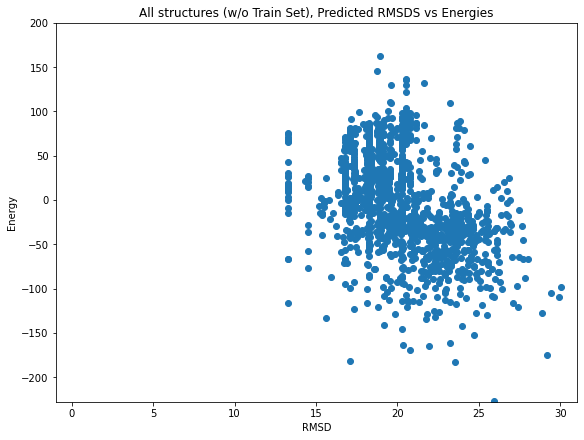

In [6]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = test(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9091579813203675, intercept=1.8185265564939073, rvalue=0.9366382501401529, pvalue=2.694587713881415e-127, stderr=0.020504017003080147, intercept_stderr=0.40753690556040806)


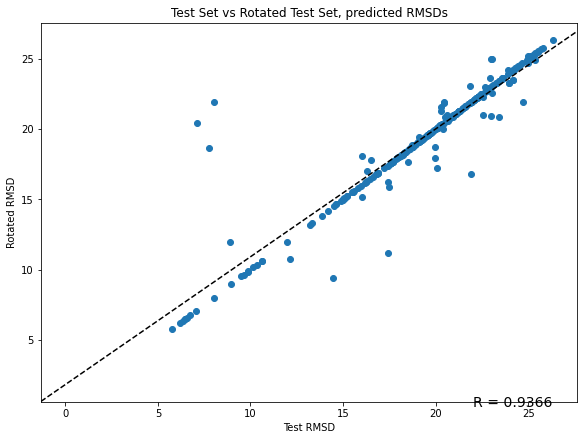

LinregressResult(slope=0.9786476636103387, intercept=0.3422918149869716, rvalue=0.9785232101141297, pvalue=1.2132055836684666e-190, stderr=0.012432089962595764, intercept_stderr=0.168440886827594)


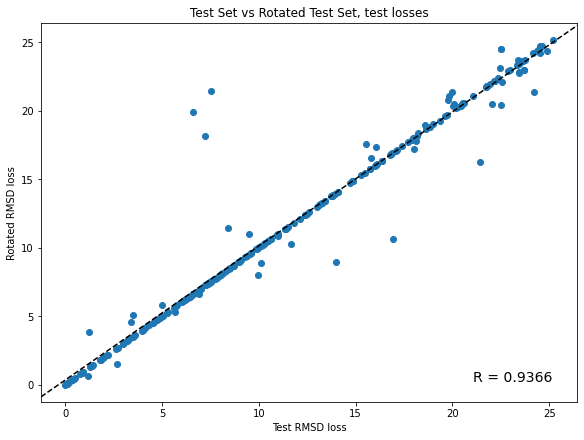

LinregressResult(slope=0.9712626165796127, intercept=0.5077173948013183, rvalue=0.9651781637725774, pvalue=0.0, stderr=0.00800650792132218, intercept_stderr=0.15077171482414378)


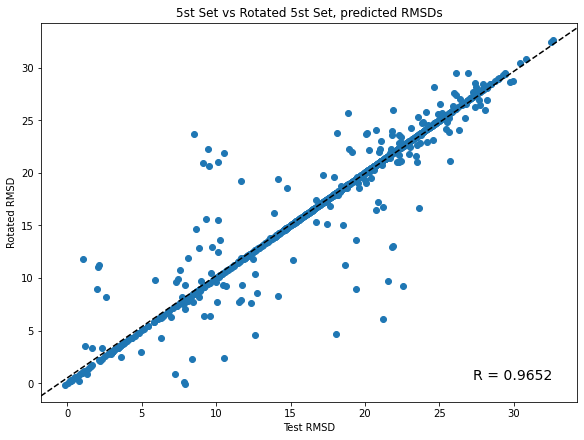

LinregressResult(slope=0.9253551594236874, intercept=0.29146281014302033, rvalue=0.9308669272310164, pvalue=0.0, stderr=0.011046561261775974, intercept_stderr=0.07107113242709055)


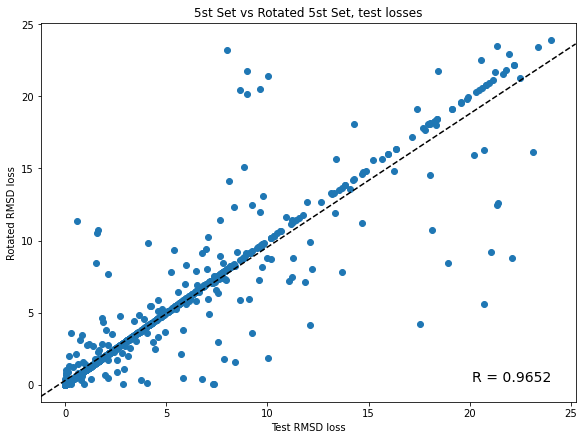

In [20]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")